# Impact Analysis

For each scenario, we'll vary the parameter of interest across a plausible range while keeping the other parameters constant.

## Import the Libraries

In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import subprocess

def is_latex_installed():
    try:
        subprocess.run(["latex"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        return True
    except FileNotFoundError:
        return False
    
if is_latex_installed():
    D_TOTAL_OLS = (r"$\newcommand{\ols}[1]{\mskip.5\thinmuskip\overline{\mskip-.5\thinmuskip {#1} \mskip-.5\thinmuskip}\mskip.5\thinmuskip}"
                   r"\ols{D}^{Total}$")
    D_TOTAL_OLS_2 = (r"$\newcommand{\ols}[1]{\mskip.5\thinmuskip\overline{\mskip-.5\thinmuskip {#1} \mskip-.5\thinmuskip}\mskip.5\thinmuskip}"
                   r"\ols{D}^{Total''}$")

    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['CMU Serif']
    plt.rcParams['font.size'] = 14
else:
    D_TOTAL_OLS = r"$\overline{D}^{Total}$"
    D_TOTAL_OLS_2 = r"$\overline{D}^{Total''}$"
    
    plt.rcParams['font.size'] = 14

## Define the Parameters

In [2]:
lambda_val  = 25     # Packet arrival rate (λ)
C_SP        = 400    # Service rate at SP (C^SP)
C_SC        = 400    # Service rate at SC (C^SC)
C_VNF       = 80     # Service rate at VNF (C^VNF)
C_PNF       = 20     # Service rate at PNF (C^PNF)
C_C         = 10     # Service rate at controller (C^C)
D_SV        = 0.0422 # Propagation delay at VNF (D^SV)
D_SC        = 0.1876 # Propagation delay at controller (D^SC)
p_N         = 0.7553 # Probability of redirecting to network function (p^N) 
p_C         = 0.5602 # Probability of redirecting to controller (p^C) 

## Define the Total Delay Function

In [3]:
def compute_total_delay(p_VNF_value, lambda_val=lambda_val, C_SP=C_SP, C_SC=C_SC, C_VNF=C_VNF, C_PNF=C_PNF, 
                        C_C=C_C, D_SV=D_SV, D_SC=D_SC, p_N=p_N, p_C=p_C):
    
    D_SP_ = 1 / (C_SP - lambda_val * (1 + p_N * p_VNF_value + p_C))
    D_SC_ = 1 / (C_SC - lambda_val * (1 + p_N * p_VNF_value + p_C))
    D_C_ = 1 / (C_C - lambda_val * p_C) + 2 * D_SC
    D_VNF_ = 1 / (C_VNF - lambda_val * p_N * p_VNF_value) + 2 * D_SV
    D_PNF_ = 1 / (C_PNF - lambda_val * p_N * (1 - p_VNF_value))

    D_Total_VNF = 2 * D_SP_ + 2 * D_SC_ + D_VNF_
    D_Total_C = 2 * D_SP_ + 2 * D_SC_ + D_C_
    D_Total_PNF = D_SP_ + D_PNF_ + D_SC_

    D_Total = p_N * p_VNF_value * D_Total_VNF + p_N * (1 - p_VNF_value) * D_Total_PNF + p_C * D_Total_C + (1 - p_N - p_C) * (D_SP_ + D_SC_)
    
    return D_Total

## Define the Core Functions

In [4]:
# Function to compute the optimization results and reference delays over a range of parameter values
def analyze_parameter_range(parameter_range, parameter_name):
    optimal_offloading_results = []
    optimal_p_VNF_values = []
    no_offloading_results = []
    full_offloading_results = []
    
    # Dictionary to map parameter names to their values for function calls
    parameter_mapping = {
        'C_C': 'C_C',
        'C_VNF': 'C_VNF',
        'lambda_val': 'lambda_val',
        'p_N': 'p_N',
        'C_PNF': 'C_PNF',
        'D_SV': 'D_SV',
        'p_C': 'p_C',
        'C_SC': 'C_SC',
        'C_SP': 'C_SP',
        'D_SC': 'D_SC'
    }
  
    for param_value in parameter_range:
        # kwargs = {parameter_mapping[parameter_name]: param_value}  # Keyword arguments for function
        kwargs = {parameter_name: param_value}
        
        # Optimization result for current parameter value
        result = minimize_scalar(lambda p_VNF_value: compute_total_delay(p_VNF_value, **kwargs), bounds=(0, 1), method='bounded')
        
        # Append results for optimal offloading, optimal p_VNF, no offloading and full offloading
        optimal_offloading_results.append(result.fun)
        optimal_p_VNF_values.append(result.x)
        no_offloading_results.append(compute_total_delay(0, **kwargs))
        full_offloading_results.append(compute_total_delay(1, **kwargs))
    
    return no_offloading_results, full_offloading_results, optimal_offloading_results, optimal_p_VNF_values

display_name_mapping = {
    'lambda_val': r"$\lambda$",
    'p_N': r"$p^N$",
    'C_PNF': r"$C^{PNF}$",
    'C_VNF': r"$C^{VNF}$",    
    'D_SV': r"$D^{SV}$",
    'p_C': r"$p^{C}$",
    'C_SC': r"$C^{SC}$",
    'C_SP': r"$C^{SP}$",
    'C_C': r"$C^{C}$",
    'D_SC': r"$D^{SC}$",    
    }

##############################################
##############################################
##############################################
##############################################

# Universal function to compute results and plot over a range of parameter values
def analyze_and_plot_parameter(parameter_range, parameter_name, x_label_unit, y_label_unit, file_name):
    
    # Compute results over the given parameter range
    no_offloading, full_offloading, optimal_offloading, optimal_p_VNF = analyze_parameter_range(parameter_range, parameter_name)

    # print(parameter_range)
    # print(no_offloading)
    # print(full_offloading)
    # print(optimal_offloading)
    # print(optimal_p_VNF)
    
    fig, ax1 = plt.subplots(figsize=(7, 5))

    ax1.set_xlabel(f'{display_name_mapping[parameter_name]} [{x_label_unit}]')
    ax1.set_ylabel(f'Total Delay [{y_label_unit}]', color='black')
    # ax1.plot(parameter_range, no_offloading, label="No Offloading", color='blue')
    ax1.plot(parameter_range, no_offloading, label=D_TOTAL_OLS+"(0)", color='blue', linestyle='-')
    # ax1.plot(parameter_range, full_offloading, label="Full Offloading", color='green')
    ax1.plot(parameter_range, full_offloading, label=D_TOTAL_OLS+"(1)", color='green', linestyle=':')
    # ax1.plot(parameter_range, optimal_offloading, label="Optimal Offloading", color='red')
    ax1.plot(parameter_range, optimal_offloading, label=D_TOTAL_OLS+r"($p^{*VNF}$)", color='red', linestyle='-.')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(linestyle='--', linewidth=0.5)

    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel(r"$p^{VNF}~[\%]$", color=color)
    ax2.plot(parameter_range, optimal_p_VNF, label=r"$p^{*VNF}$", color='orange', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0, 1])  # Set fixed y-axis range for p_VNF values

    # Merging legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Manually order the lines and labels
    ordered_lines = [lines1[0], lines1[1], lines1[2], lines2[0]]
    ordered_labels = [labels1[0], labels1[1], labels1[2], labels2[0]]
    
    ax2.legend(ordered_lines, ordered_labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)
    
    # plt.title(f'Impact of {display_name_mapping[parameter_name]} on Offloading Decisions')
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig('fig/'+file_name+'.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

##############################################
##############################################
##############################################
##############################################

def analyze_and_plot_parameter_lambda(parameter_range, parameter_name, x_label_unit, y_label_unit, file_name):
    
    # Compute results over the given parameter range
    no_offloading, full_offloading, optimal_offloading, optimal_p_VNF = analyze_parameter_range(parameter_range, parameter_name)
    
    # Plotting the results
    fig, ax1 = plt.subplots(figsize=(7, 5))

    def find_nearest_indices(array, values):
        indices = []
        for value in values:
            index = (np.abs(array - value)).argmin()
            indices.append(index)
        return indices

    # markevery_values = [22, 23, 24, 25, 26]
    markevery_values = [22, 22.5, 23, 23.5, 24, 24.5, 25, 25.5, 26]
    markevery_indices = find_nearest_indices(parameter_range, markevery_values)

    ax1.set_xlabel(f'{display_name_mapping[parameter_name]} [{x_label_unit}]')
    ax1.set_ylabel(f'Total Delay [{y_label_unit}]', color='black')
    ax1.plot(parameter_range, no_offloading, label=D_TOTAL_OLS+"(0)", color='blue', linestyle='-', marker='o', markevery=markevery_indices)
    ax1.plot(parameter_range, full_offloading, label=D_TOTAL_OLS+"(1)", color='green', linestyle=':', marker='s', markevery=markevery_indices)
    ax1.plot(parameter_range, optimal_offloading, label=D_TOTAL_OLS+r"($p^{*VNF}$)", color='red', linestyle='-.', marker='^', markevery=markevery_indices)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(linestyle='--', linewidth=0.5)
   
    ax2 = ax1.twinx()
    ax2color = 'tab:orange' # darkorange, goldenrod, darkgoldenrod
    ax2.set_ylabel(r"$p^{VNF}~[\%]$", color=ax2color)
    ax2.plot(parameter_range, optimal_p_VNF, label=r"$p^{*VNF}$", color=ax2color, linestyle='--', marker='*', markevery=markevery_indices)
    ax2.tick_params(axis='y', labelcolor=ax2color)
    ax2.set_ylim([0, 1])  # Set fixed y-axis range for p_VNF values

    # Merging legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Manually order the lines and labels
    ordered_lines = [lines1[0], lines1[1], lines1[2], lines2[0]]
    ordered_labels = [labels1[0], labels1[1], labels1[2], labels2[0]]
    
    ax2.legend(ordered_lines, ordered_labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)
    
    # plt.title(f'Impact of {display_name_mapping[parameter_name]} on Offloading Decisions')
    plt.tight_layout()
    align_yaxis(ax1, ax2)
    plt.savefig('fig/'+file_name+'.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = np.array([extr[1] / (extr[1] - extr[0]) for extr in extrema])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in [axes, extrema, tops]]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0, 1] = extrema[0, 0] + tot_span * (extrema[0, 1] - extrema[0, 0])
    extrema[1, 0] = extrema[1, 1] + tot_span * (extrema[1, 0] - extrema[1, 1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]

##############################################
##############################################
##############################################
##############################################

def analyze_and_plot_parameter_p_N(parameter_range, parameter_name, x_label_unit, y_label_unit, file_name):
    
    # Compute results over the given parameter range
    no_offloading, full_offloading, optimal_offloading, optimal_p_VNF = analyze_parameter_range(parameter_range, parameter_name)
    
    # Plotting the results
    fig, ax1 = plt.subplots(figsize=(7, 5))

    def find_nearest_indices(array, values):
        indices = []
        for value in values:
            index = (np.abs(array - value)).argmin()
            indices.append(index)
        return indices

    markevery_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
    markevery_values_b = [0, 0.2, 0.4, 0.6]
    markevery_values_g = [0.2, 0.4, 0.6, 0.8, 1]
    markevery_indices = find_nearest_indices(parameter_range, markevery_values)
    markevery_indices_b = find_nearest_indices(parameter_range, markevery_values_b)
    markevery_indices_g = find_nearest_indices(parameter_range, markevery_values_g)
    # Calculate adjusted markevery indices for truncated data for ax2
    adjusted_markevery_indices_g = [index - 1 for index in markevery_indices_g if index >= 1]

    ax1.set_xlabel(f'{display_name_mapping[parameter_name]} [{x_label_unit}]')
    ax1.set_ylabel(f'Total Delay [{y_label_unit}]', color='black')
    ax1.plot(parameter_range[:80], no_offloading[:80], label=D_TOTAL_OLS+"(0)", color='blue', linestyle='-', marker='o', markevery=markevery_indices_b)
    ax1.plot(parameter_range, full_offloading, label=D_TOTAL_OLS+"(1)", color='green', linestyle=':', marker='s', markevery=markevery_indices)
    ax1.plot(parameter_range, optimal_offloading, label=D_TOTAL_OLS+r"($p^{*VNF}$)", color='red', linestyle='-.', marker='^', markevery=markevery_indices)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.set_ylim(-1,15)

    ax2 = ax1.twinx()    
    ax2color = 'tab:orange' # darkorange, goldenrod, darkgoldenrod
    ax2.set_ylabel(r"$p^{VNF}~[\%]$", color=ax2color)
    # ax2.plot(parameter_range, optimal_p_VNF, label=r"Optimal $p^{VNF}$", color='orange', linestyle='--')
    ax2.plot(parameter_range[1:], optimal_p_VNF[1:], label=r"$p^{*VNF}$", color=ax2color, linestyle='--', marker='*', markevery=adjusted_markevery_indices_g)
    ax2.tick_params(axis='y', labelcolor=ax2color)
    ax2.set_ylim(0,1)  # Set fixed y-axis range for p_VNF values
   
    # Merging legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Manually order the lines and labels
    ordered_lines = [lines1[0], lines1[1], lines1[2], lines2[0]]
    ordered_labels = [labels1[0], labels1[1], labels1[2], labels2[0]]
    
    ax2.legend(ordered_lines, ordered_labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)
    
    # plt.title(f'Impact of {display_name_mapping[parameter_name]} on Offloading Decisions')
    plt.tight_layout()
    # ax1.set_ylim(0)
    align_yaxis(ax1, ax2)
    plt.savefig('fig/'+file_name+'.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

##############################################
##############################################
##############################################
##############################################

def analyze_and_plot_parameter_C_PNF(parameter_range, parameter_name, x_label_unit, y_label_unit, file_name):
    
    # Compute results over the given parameter range
    no_offloading, full_offloading, optimal_offloading, optimal_p_VNF = analyze_parameter_range(parameter_range, parameter_name)
    
    # Plotting the results
    fig, ax1 = plt.subplots(figsize=(7, 5))

    def find_nearest_indices(array, values):
        indices = []
        for value in values:
            index = (np.abs(array - value)).argmin()
            indices.append(index)
        return indices

    markevery_values = [20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40]
    markevery_indices = find_nearest_indices(parameter_range, markevery_values)

    ax1.set_xlabel(f'{display_name_mapping[parameter_name]} [{x_label_unit}]')
    ax1.set_ylabel(f'Total Delay [{y_label_unit}]', color='black')
    ax1.plot(parameter_range, no_offloading, label=D_TOTAL_OLS+"(0)", color='blue', linestyle='-', marker='o', markevery=markevery_indices)
    ax1.plot(parameter_range, full_offloading, label=D_TOTAL_OLS+"(1)", color='green', linestyle=':', marker='s', markevery=markevery_indices)
    ax1.plot(parameter_range, optimal_offloading, label=D_TOTAL_OLS+r"($p^{*VNF}$)", color='red', linestyle='-.', marker='^', markevery=markevery_indices)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.set_ylim(-0.05,0.8)

    ax2 = ax1.twinx()    
    ax2color = 'tab:orange' # darkorange, goldenrod, darkgoldenrod
    ax2.set_ylabel(r"$p^{VNF}~[\%]$", color=ax2color)
    # ax2.plot(parameter_range, optimal_p_VNF, label=r"Optimal $p^{VNF}$", color='orange', linestyle='--')
    ax2.plot(parameter_range, optimal_p_VNF, label=r"$p^{*VNF}$", color=ax2color, linestyle='--', marker='*', markevery=markevery_indices)
    ax2.tick_params(axis='y', labelcolor=ax2color)
    ax2.set_ylim(0,1)  # Set fixed y-axis range for p_VNF values
   
    # Merging legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Manually order the lines and labels
    ordered_lines = [lines1[0], lines1[1], lines1[2], lines2[0]]
    ordered_labels = [labels1[0], labels1[1], labels1[2], labels2[0]]
    
    ax2.legend(ordered_lines, ordered_labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)
    
    # plt.title(f'Impact of {display_name_mapping[parameter_name]} on Offloading Decisions')
    plt.tight_layout()
    align_yaxis(ax1, ax2)
    plt.savefig('fig/'+file_name+'.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

##############################################
##############################################
##############################################
##############################################

def analyze_and_plot_parameter_C_VNF(parameter_range, parameter_name, x_label_unit, y_label_unit, file_name):
    
    # Compute results over the given parameter range
    no_offloading, full_offloading, optimal_offloading, optimal_p_VNF = analyze_parameter_range(parameter_range, parameter_name)
    
    # Plotting the results
    fig, ax1 = plt.subplots(figsize=(7, 5))

    def find_nearest_indices(array, values):
        indices = []
        for value in values:
            index = (np.abs(array - value)).argmin()
            indices.append(index)
        return indices

    markevery_values = [20, 40, 60, 80, 100, 120, 140]
    markevery_indices = find_nearest_indices(parameter_range, markevery_values)

    ax1.set_xlabel(f'{display_name_mapping[parameter_name]} [{x_label_unit}]')
    ax1.set_ylabel(f'Total Delay [{y_label_unit}]', color='black')
    ax1.plot(parameter_range, no_offloading, label=D_TOTAL_OLS+"(0)", color='blue', linestyle='-', marker='o', markevery=markevery_indices)
    ax1.plot(parameter_range, full_offloading, label=D_TOTAL_OLS+"(1)", color='green', linestyle=':', marker='s', markevery=markevery_indices)
    ax1.plot(parameter_range, optimal_offloading, label=D_TOTAL_OLS+r"($p^{*VNF}$)", color='red', linestyle='-.', marker='^', markevery=markevery_indices)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(linestyle='--', linewidth=0.5)
    ax1.set_ylim(-0.05,0.9)

    ax2 = ax1.twinx()    
    ax2color = 'tab:orange' # darkorange, goldenrod, darkgoldenrod
    ax2.set_ylabel(r"$p^{VNF}~[\%]$", color=ax2color)
    # ax2.plot(parameter_range, optimal_p_VNF, label=r"Optimal $p^{VNF}$", color='orange', linestyle='--')
    ax2.plot(parameter_range, optimal_p_VNF, label=r"$p^{*VNF}$", color=ax2color, linestyle='--', marker='*', markevery=markevery_indices)
    ax2.tick_params(axis='y', labelcolor=ax2color)
    ax2.set_ylim(0,1)  # Set fixed y-axis range for p_VNF values
   
    # Merging legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Manually order the lines and labels
    ordered_lines = [lines1[0], lines1[1], lines1[2], lines2[0]]
    ordered_labels = [labels1[0], labels1[1], labels1[2], labels2[0]]
    
    ax2.legend(ordered_lines, ordered_labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)
    
    # plt.title(f'Impact of {display_name_mapping[parameter_name]} on Offloading Decisions')
    plt.tight_layout()
    align_yaxis(ax1, ax2)
    plt.savefig('fig/'+file_name+'.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
def analyze_and_plot_parameter_D_SV(parameter_range, parameter_name, x_label_unit, y_label_unit, file_name):
    
    # Compute results over the given parameter range
    no_offloading, full_offloading, optimal_offloading, optimal_p_VNF = analyze_parameter_range(parameter_range, parameter_name)
    
    # Plotting the results
    fig, ax1 = plt.subplots(figsize=(7, 5))

    def find_nearest_indices(array, values):
        indices = []
        for value in values:
            index = (np.abs(array - value)).argmin()
            indices.append(index)
        return indices

    markevery_values = [0, 0.2, 0.4, 0.6, .8, 1]
    markevery_indices = find_nearest_indices(parameter_range, markevery_values)

    ax1.set_xlabel(f'{display_name_mapping[parameter_name]} [{x_label_unit}]')
    ax1.set_ylabel(f'Total Delay [{y_label_unit}]', color='black')
    ax1.plot(parameter_range, no_offloading, label=D_TOTAL_OLS+"(0)", color='blue', linestyle='-', marker='o', markevery=markevery_indices)
    ax1.plot(parameter_range, full_offloading, label=D_TOTAL_OLS+"(1)", color='green', linestyle=':', marker='s', markevery=markevery_indices)
    ax1.plot(parameter_range, optimal_offloading, label=D_TOTAL_OLS+r"($p^{*VNF}$)", color='red', linestyle='-.', marker='^', markevery=markevery_indices)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(linestyle='--', linewidth=0.5)
    # ax1.set_ylim(-0.05,0.9)

    ax2 = ax1.twinx()    
    ax2color = 'tab:orange' # darkorange, goldenrod, darkgoldenrod
    ax2.set_ylabel(r"$p^{VNF}~[\%]$", color=ax2color)
    # ax2.plot(parameter_range, optimal_p_VNF, label=r"Optimal $p^{VNF}$", color='orange', linestyle='--')
    ax2.plot(parameter_range, optimal_p_VNF, label=r"$p^{*VNF}$", color=ax2color, linestyle='--', marker='*', markevery=markevery_indices)
    ax2.tick_params(axis='y', labelcolor=ax2color)
    ax2.set_ylim(0,1)  # Set fixed y-axis range for p_VNF values
   
    # Merging legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Manually order the lines and labels
    ordered_lines = [lines1[0], lines1[1], lines1[2], lines2[0]]
    ordered_labels = [labels1[0], labels1[1], labels1[2], labels2[0]]
    
    ax2.legend(ordered_lines, ordered_labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)
    
    # plt.title(f'Impact of {display_name_mapping[parameter_name]} on Offloading Decisions')
    plt.tight_layout()
    align_yaxis(ax1, ax2)
    plt.savefig('fig/'+file_name+'.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_and_plot_parameter_p_C(parameter_range, parameter_name, x_label_unit, y_label_unit, file_name):
    
    # Compute results over the given parameter range
    no_offloading, full_offloading, optimal_offloading, optimal_p_VNF = analyze_parameter_range(parameter_range, parameter_name)
    
    # Plotting the results
    fig, ax1 = plt.subplots(figsize=(7, 5))

    def find_nearest_indices(array, values):
        indices = []
        for value in values:
            index = (np.abs(array - value)).argmin()
            indices.append(index)
        return indices

    markevery_values = [0, 0.2, 0.4, 0.6, 0.8, 1]
    markevery_values_b = [0, 0.2]
    markevery_indices = find_nearest_indices(parameter_range, markevery_values)
    markevery_indices_b = find_nearest_indices(parameter_range, markevery_values_b)
 
    ax1.set_xlabel(f'{display_name_mapping[parameter_name]} [{x_label_unit}]')
    ax1.set_ylabel(f'Total Delay [{y_label_unit}]', color='black')
    ax1.plot(parameter_range[:39], no_offloading[:39], label=D_TOTAL_OLS+"(0)", color='blue', linestyle='-', marker='o', markevery=markevery_indices_b)
    ax1.plot(parameter_range[:39], full_offloading[:39], label=D_TOTAL_OLS+"(1)", color='green', linestyle=':', marker='s', markevery=markevery_indices_b)
    ax1.plot(parameter_range[:39], optimal_offloading[:39], label=D_TOTAL_OLS+r"($p^{*VNF}$)", color='red', linestyle='-.', marker='^', markevery=markevery_indices_b)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(linestyle='--', linewidth=0.5)
    # ax1.set_ylim(-1,15)

    ax2 = ax1.twinx()    
    ax2color = 'tab:orange' # darkorange, goldenrod, darkgoldenrod
    ax2.set_ylabel(r"$p^{VNF}~[\%]$", color=ax2color)
    # ax2.plot(parameter_range, optimal_p_VNF, label=r"Optimal $p^{VNF}$", color='orange', linestyle='--')
    ax2.plot(parameter_range, optimal_p_VNF, label=r"$p^{*VNF}$", color=ax2color, linestyle='--', marker='*', markevery=markevery_indices)
    ax2.tick_params(axis='y', labelcolor=ax2color)
    ax2.set_ylim(0,1)  # Set fixed y-axis range for p_VNF values
   
    # Merging legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Manually order the lines and labels
    ordered_lines = [lines1[0], lines1[1], lines1[2], lines2[0]]
    ordered_labels = [labels1[0], labels1[1], labels1[2], labels2[0]]
    
    ax2.legend(ordered_lines, ordered_labels,
               bbox_to_anchor=(0., 1.02, 1., .102),
               loc='lower left',
               ncol=2,
               mode="expand",
               borderaxespad=0.,
               fancybox=True,
               shadow=True)
    
    # plt.title(f'Impact of {display_name_mapping[parameter_name]} on Offloading Decisions')
    plt.tight_layout()
    # ax1.set_ylim(0)
    align_yaxis(ax1, ax2)
    plt.savefig('fig/'+file_name+'.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()
    
# def percentage_difference(val1, val2):
#     return abs((val1 - val2) / val1) * 100

# a = 0.15975347505438978
# b = 0.1502872747889204
# perc_diff = percentage_difference(a, b)
# perc_diff  

## Impact of $λ$

In this scenario, we analyze the effect of varying the packet arrival rate, $λ$, on offloading decisions. A higher $λ$ suggests that more packets are arriving at the P4 switch, potentially increasing the load and congestion.
We vary $λ$ over a plausible range and observe its influence on offloading decisions.

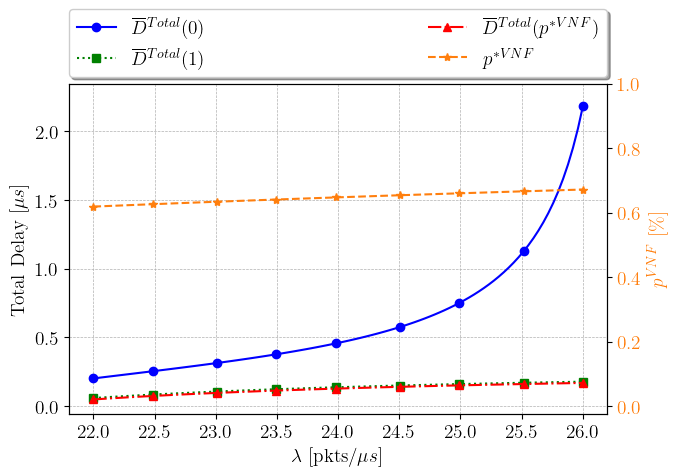

In [5]:
PARAMETER_NAME = 'lambda_val'
LAMBDA = np.linspace(22, 26, 100)
PARAMETER_RANGE = LAMBDA
X_LABEL_UNIT = r"pkts/$\mu s$"
Y_LABEL_UNIT = r"$\mu s$"
FILE_NAME = "lambda"

analyze_and_plot_parameter_lambda(PARAMETER_RANGE, PARAMETER_NAME, X_LABEL_UNIT, Y_LABEL_UNIT, FILE_NAME)

## Impact of $p^N$

In this scenario, we analyze the effect of varying the proportion of packets that need processing, represented by $p^N$, on offloading decisions. A higher $p^N$ indicates that a greater fraction of the incoming packets require some form of processing, either at the P4 switch, VNF, or PNF. We vary $p^N$ over its valid range, which is [0, 1].

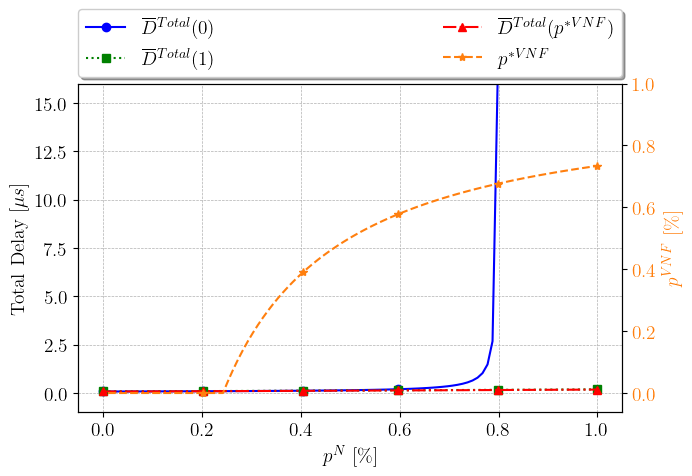

In [6]:
PARAMETER_NAME = 'p_N'
PN = np.linspace(0.00, 1.00, 100)
PARAMETER_RANGE = PN
X_LABEL_UNIT = r"$\%$"
Y_LABEL_UNIT = r"$\mu s$"
FILE_NAME = "p_N"

analyze_and_plot_parameter_p_N(PARAMETER_RANGE, PARAMETER_NAME, X_LABEL_UNIT, Y_LABEL_UNIT, FILE_NAME)

## Impact of $C^{PNF}$

In this scenario, we analyze the effect of varying the capacity of the PNF, represented by $C^{PNF}$, on offloading decisions. The capacity of the PNF denotes its ability to process packets; a higher capacity means it can handle more packets per unit of time.

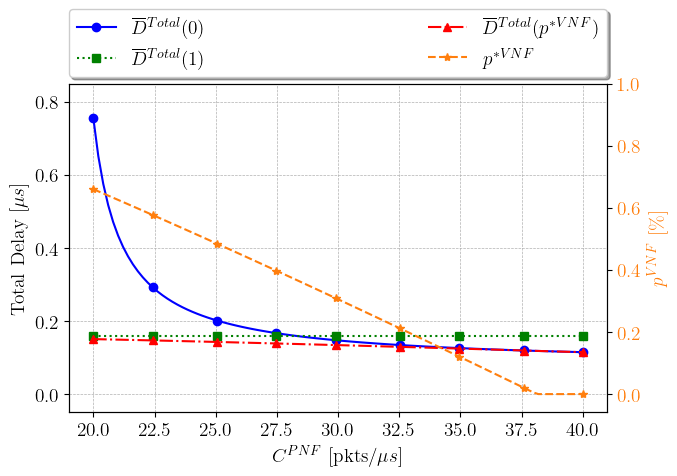

In [7]:
PARAMETER_NAME = 'C_PNF'
CPNF = np.linspace(20, 40, 100)
PARAMETER_RANGE = CPNF
X_LABEL_UNIT = r"pkts/$\mu s$"
Y_LABEL_UNIT = r"$\mu s$"
FILE_NAME = "C_PNF"

analyze_and_plot_parameter_C_PNF(PARAMETER_RANGE, PARAMETER_NAME, X_LABEL_UNIT, Y_LABEL_UNIT, FILE_NAME)

## Impact of $C_{VNF}$

In this scenario, we analyze the effect of varying the capacity of the VNF, represented by $C^{VNF}$, on offloading decisions. The capacity of the VNF denotes its ability to process packets; a higher capacity means it can handle more packets per unit of time.

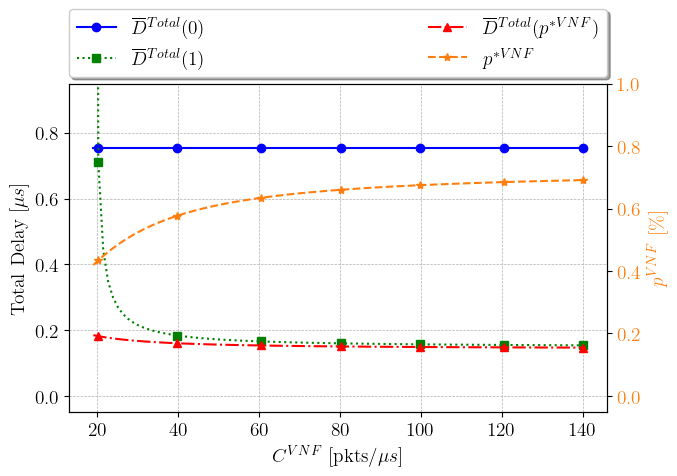

In [8]:
PARAMETER_NAME = 'C_VNF'
CVNF = np.linspace(19, 140, 100)
PARAMETER_RANGE = CVNF
X_LABEL_UNIT = r"pkts/$\mu s$"
Y_LABEL_UNIT = r"$\mu s$"
FILE_NAME = "C_VNF"

analyze_and_plot_parameter_C_VNF(PARAMETER_RANGE, PARAMETER_NAME, X_LABEL_UNIT, Y_LABEL_UNIT, FILE_NAME)

## Impact of $D^{SV}$

In this scenario, we analyze the effect of varying the fixed propagation delay between the P4 switch and the VNF, represented by $D^{SV}$, on offloading decisions. This delay can be influenced by factors like the physical distance between the components, network congestion, or other network-specific attributes.

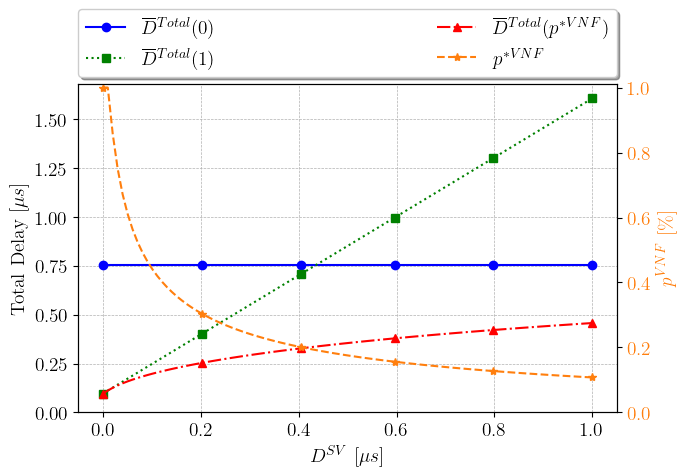

In [9]:
PARAMETER_NAME = 'D_SV'
DSV = np.linspace(0, 1, 100)
PARAMETER_RANGE = DSV
X_LABEL_UNIT = r"$\mu s$"
Y_LABEL_UNIT = r"$\mu s$"
FILE_NAME = "D_SV"

analyze_and_plot_parameter_D_SV(PARAMETER_RANGE, PARAMETER_NAME, X_LABEL_UNIT, Y_LABEL_UNIT, FILE_NAME)

## Impact of $p^C$

For analysing the impact of the table miss probability ($p^C$), we use the full valid range [0, 1]

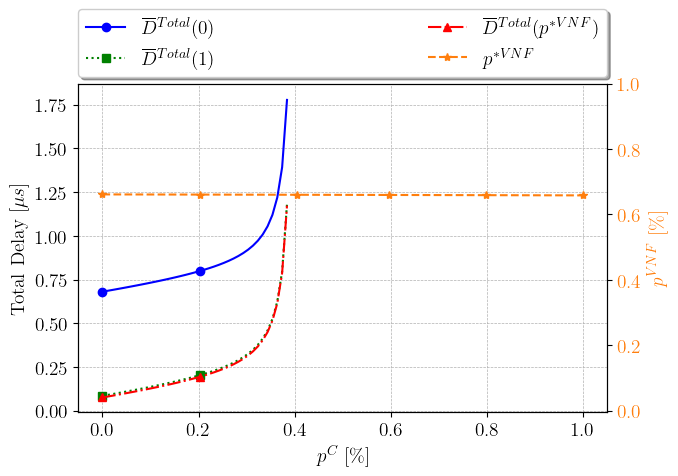

In [11]:
PARAMETER_NAME = 'p_C'
DSV = np.linspace(0, 1, 100)
PARAMETER_RANGE = DSV
X_LABEL_UNIT = r"$\%$"
Y_LABEL_UNIT = r"$\mu s$"
FILE_NAME = "p_C"

analyze_and_plot_parameter_p_C(PARAMETER_RANGE, PARAMETER_NAME, X_LABEL_UNIT, Y_LABEL_UNIT, FILE_NAME)

## $C^C$

In this scenario, we vary the capacity of the SDN controller ($C^C$) to see how offloading decisions change when the controller is under significant load.

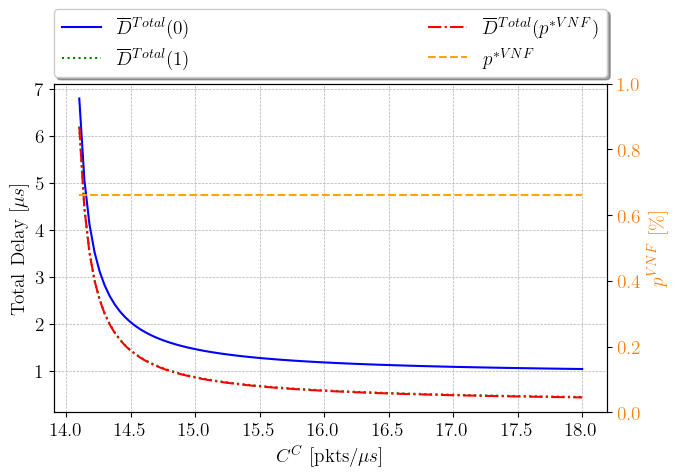

In [12]:
PARAMETER_NAME = 'C_C'
PARAMETER_RANGE = np.linspace(14.1, 18, 100)
X_LABEL_UNIT = r"pkts/$\mu s$"
Y_LABEL_UNIT = r"$\mu s$"
LABEL_NAME = 'C_C'
    
analyze_and_plot_parameter(PARAMETER_RANGE, PARAMETER_NAME, X_LABEL_UNIT, Y_LABEL_UNIT, LABEL_NAME)

## $C^{SC}$
 
In this scenario, we analyze the effect of varying the capacity of the P4 switch for communication, represented by $C^{SC}$, on offloading decisions. This sheds light on how efficient communication capabilities of the switch influence the overall system performance.

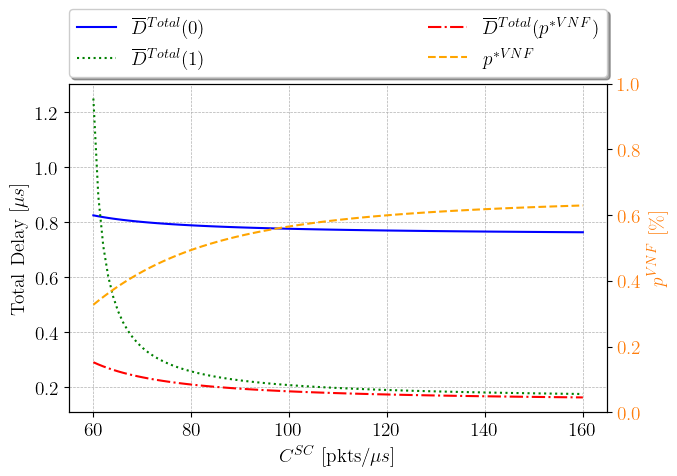

In [13]:
PARAMETER_NAME = 'C_SC'
PARAMETER_RANGE = np.linspace(60, 160, 100)
X_LABEL_UNIT = r"pkts/$\mu s$"
Y_LABEL_UNIT = r"$\mu s$"
FILE_NAME = 'C_SC'

analyze_and_plot_parameter(PARAMETER_RANGE, PARAMETER_NAME, X_LABEL_UNIT, Y_LABEL_UNIT, FILE_NAME)

## $C^{SP}$

In this scenario, we analyze the effect of varying the capacity of the P4 switch for processing, represented by $C^{SP}$, on offloading decisions. This provides insights into how the switch's processing power influences the overall system delay and offloading decisions.

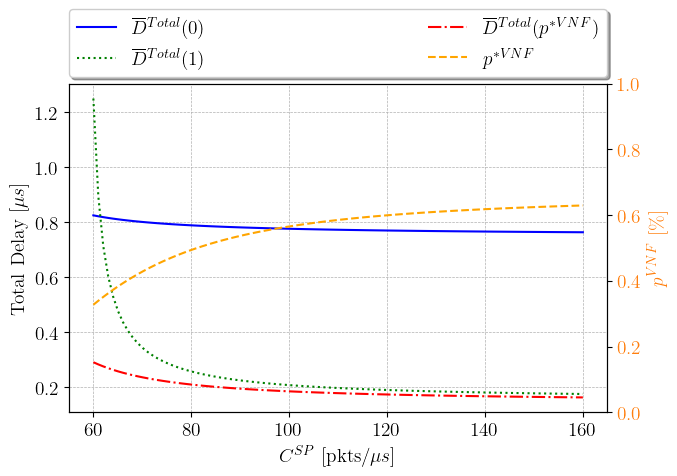

In [14]:
PARAMETER_NAME = 'C_SP'
PARAMETER_RANGE = np.linspace(60, 160, 100)
X_LABEL_UNIT = r"pkts/$\mu s$"
Y_LABEL_UNIT = r"$\mu s$"
FILE_NAME = 'C_SP'

analyze_and_plot_parameter(PARAMETER_RANGE, PARAMETER_NAME, X_LABEL_UNIT, Y_LABEL_UNIT, FILE_NAME)